Text(0, 0.5, 'Amount of adjustments')

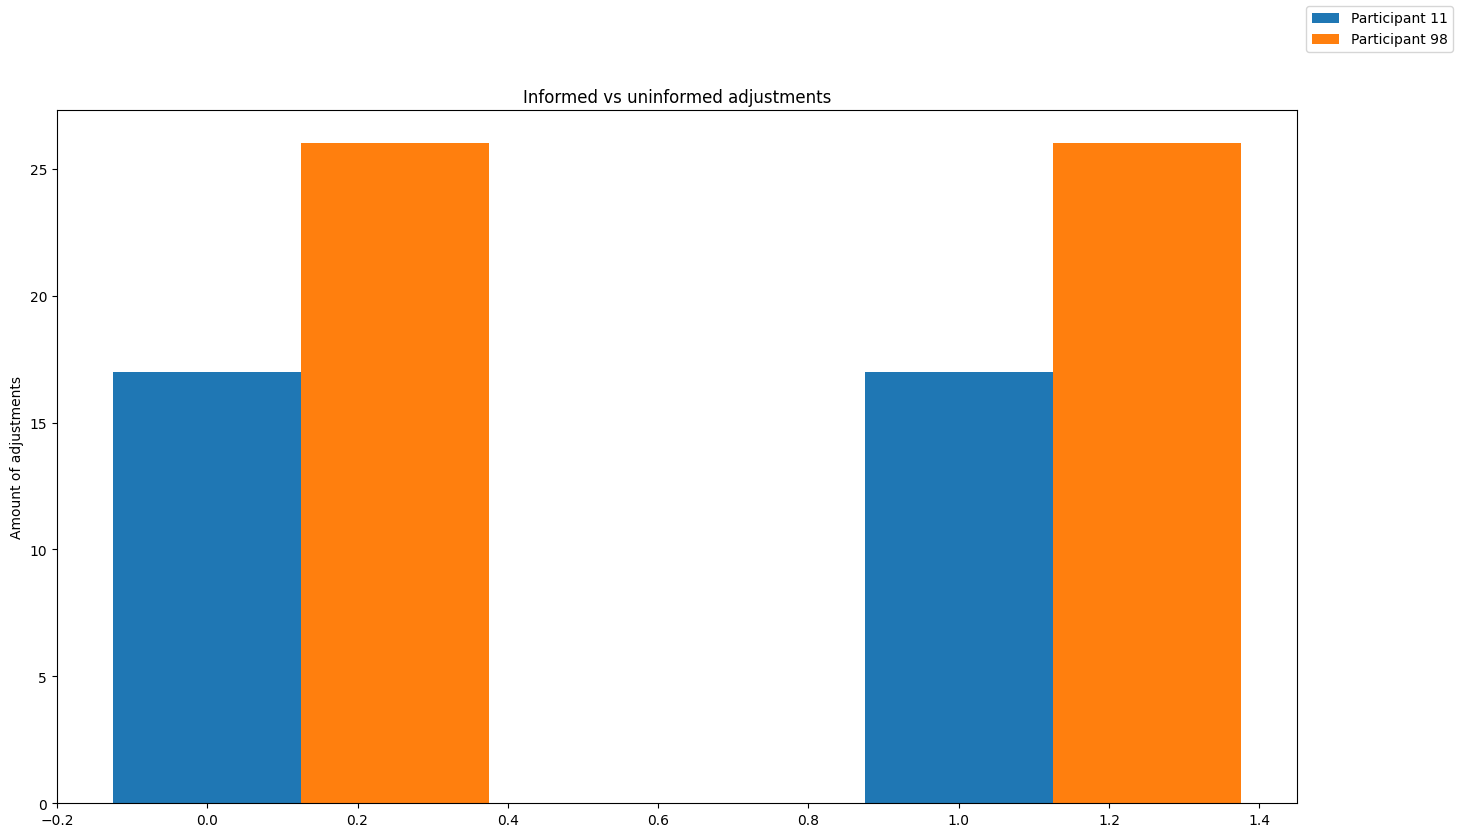

In [1]:
import numpy as np
from utils import Events
import matplotlib.pyplot as plt
from peewee import fn

INFORMED_TREATMENTS = ["Treatment 2,1", "Treatment 2,2", "Treatment 2,3"]
UNINFORMED_TREATMENTS = ["Treatment 2,4", "Treatment 2,5", "Treatment 2,6"]
SPLIT1_TREATMENTS = ["Treatment 1,1", "Treatment 1,2", "Treatment 1,3", "Treatment 1,4"]

UNINFORMED_PARTICIPANTS = (
    Events.select(
        Events.participant_id,
        fn.COUNT().alias("event_count"),
    )
    .where(
        (Events.event.startswith("SET_"))
        & Events.participant_id.in_(
            Events.select(Events.participant_id).where(
                (Events.new_value.in_(UNINFORMED_TREATMENTS))
            )
        )
    )
    .group_by(Events.participant_id)
)


INFORMED_PARTICIPANTS = (
    Events.select(
        Events.participant_id,
        Events.time,
        fn.COUNT().alias("event_count"),
    )
    .where(
        (Events.event.startswith("SET_"))
        & Events.participant_id.in_(
            Events.select(Events.participant_id).where(
                (Events.new_value.in_(INFORMED_TREATMENTS))
            )
        )
    )
    .group_by(Events.participant_id)
)

SPLIT1_PARTICIPANTS = (
    Events.select(
        Events.participant_id,
        fn.COUNT().alias("event_count"),
    )
    .where(
        (Events.event.startswith("SET_"))
        & Events.participant_id.in_(
            Events.select(Events.participant_id).where(
                (Events.new_value.in_(SPLIT1_TREATMENTS))
            )
        )
    )
    .group_by(Events.participant_id)
)


x = np.arange(
    INFORMED_PARTICIPANTS.count() + UNINFORMED_PARTICIPANTS.count()
)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Informed vs uninformed adjustments")

for p in INFORMED_PARTICIPANTS:
    offset = width * multiplier
    ax.bar(
        x + offset,
        label=f"Participant {p.participant_id}",
        height=p.event_count,
        width=width,
    )
    multiplier +=1

# bottom = 0
# for p in SPLIT1_PARTICIPANTS:
#     ax.bar(
#         label=f"Participant {p.participant_id}",
#         x="Split 1",
#         height=p.event_count,
#         bottom=bottom,
#     )
#     bottom += p.event_count

# Populationen er 14, 8 er blevet informerert, 2 af de informerede har ændret noget

# ax.set_xticks(["Informed", "Uninformed", "Split 1"])

fig.legend()

ax.set_ylabel("Amount of adjustments")

Participant : 98 read 3 books


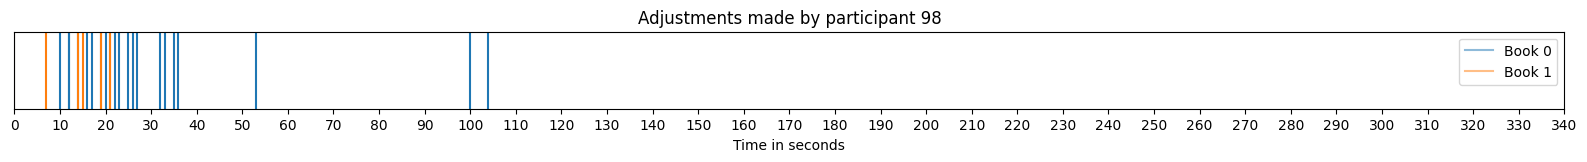

Participant : 11 read 3 books


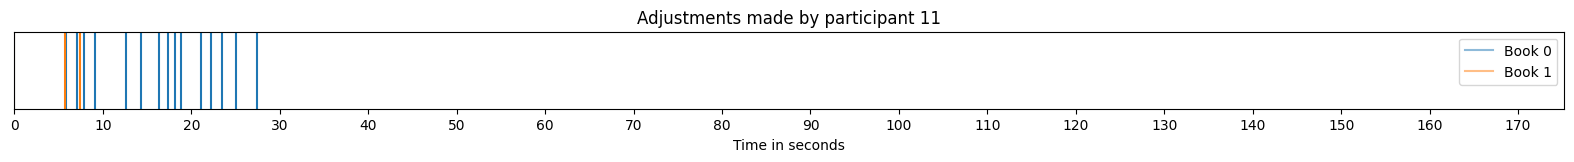

In [7]:
# Make a plot of the amount of adjustments made vs time

PARTICIPANT_IDS_IN_SPLIT2 = Events.select(Events.participant_id).where(
    (Events.event == "SELECT_TREATMENT") & (Events.new_value.not_in(SPLIT1_TREATMENTS))
)
# Filter out those who did not make any adjustments
PARTICIPANTS_WITH_ADJUSTMENTS = (
    Events.select(Events.participant_id)
    .where(
        (Events.event.startswith("SET_"))
        & (Events.participant_id.in_(PARTICIPANT_IDS_IN_SPLIT2))
    )
    .distinct()
)

subquery = Events.select().where(
    Events.participant_id.in_(PARTICIPANTS_WITH_ADJUSTMENTS)
)

for p in PARTICIPANTS_WITH_ADJUSTMENTS:
    books = subquery.where(
        (Events.event == "OPEN_BOOK") & (Events.participant_id == p.participant_id)
    ).order_by(Events.time)
    fig, ax = plt.subplots(figsize=(20, 1))
    book_nr = 0
    print(f"Participant : {p.participant_id} read {books.count()} books")
    for book in books:
        if book_nr >= 2:
            break
        START_TIME_BOOK = book.time
        book_end = subquery.where(
            (Events.event == "CLOSE_BOOK")
            & (Events.time > START_TIME_BOOK)
            & (Events.participant_id == p.participant_id)
        ).get_or_none()
        if book_end is None:
            continue
        END_TIME_BOOK = book_end.time
        # Get all adjustments made in this book
        adjustments = subquery.where(
            (Events.event.startswith("SET_"))
            & (Events.time > START_TIME_BOOK)
            & (Events.time < END_TIME_BOOK)
            & (Events.participant_id == p.participant_id)
        )

        # Make time relative to 0
        adjustments = list(adjustments)

        for a in adjustments:
            a.time -= START_TIME_BOOK
            # Color based on book
            # For participant with id 11, make time into seconds from milliseconds
            if p.participant_id == 11:
                a.time /= 1000
            ax.axvline(a.time, color=f"C{book_nr}")


        ax.set_title(f"Adjustments made by participant {p.participant_id}")
        ax.set_xlim(0, END_TIME_BOOK - START_TIME_BOOK)
        ax.set_yticks([])
        if p.participant_id == 11:
            ax.set_xlim(0, END_TIME_BOOK / 1000 - START_TIME_BOOK / 1000)
        ax.set_xlabel("Time in seconds")
        # More granular x axis
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        # Set label for book
        ax.axvline(0, color=f"C{book_nr}", label=f"Book {book_nr}", alpha=0.5)
        # Along the x axis, set a label for each adjustment
        book_nr += 1
    plt.legend()
    plt.show()